In [ ]:
! conda install -c conda-forge --yes hdbscan
! conda install -c conda-forge --yes spacy
! pip install allennlp
! python -m spacy download en
! python -m spacy download en_core_web_lg
! pip install --quiet keras tensorflow
! pip install --quiet hdmedians
! pip install --quiet joblib

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

import pandas as pd
pd.set_option('display.width', 800)

from joblib import Memory
mem = Memory('tasks-joblib', verbose=0)

In [41]:
import spacy
import numpy as np
import seaborn as sns
from scipy.spatial.distance import squareform, pdist

def is_verb(token):
    if not token.pos_ == 'VERB':
        return False
    if token.dep_ in ['acl', 'amod', 'prep'] and token.head.pos_ == 'NOUN':
        return False
    if token.dep_ in ['ccomp', 'advcl'] and token.head.pos_ == 'VERB':
        return False
    return True

def get_head(doc):
    return [t for t in doc if t.head == t][0]

def get_verbs(doc):
    return [t for t in doc if is_verb(t)]

def get_descendents(token):
    children = [c for c in token.children if not is_verb(c)]
    desc = [d for c in children for d in get_descendents(c)]
    return desc + [token]

def is_stop(t):
    return t.is_stop or len(str(t)) == 1 or t.pos_ in ['PUNCT', 'PART']

def get_objs(v):
    return [c for c in v.children 
            if c.dep_ in ['dobj', 'prep', 'ccomp', 'advcl']]

def get_np(verb):    
    children = get_objs(verb)
    other_verbs = [c for c in verb.children if c.dep_ in ['conj']]
    verbs = [verb]

    if other_verbs and not children:
        verbs += other_verbs
        children = [i for v in other_verbs for i in get_objs(v)]

    noun_phrase = [d for c in children 
                   for d in get_descendents(c) 
                   if not is_stop(d)]

    noun_phrase = sorted(noun_phrase, key=lambda t: t.i)

    return [' '.join(map(str, x)) for x in [verbs, noun_phrase]]

def parse_sent(sent):
    nps = [get_np(v) for v in get_verbs(sent)]    
    nouns,verbs = [],[]
    for v,n in nps:
        if n and not n in nouns:
            verbs += [v]
            nouns += [n]
    return list(zip(verbs, nouns))

@mem.cache()
def parse_tasks(tasks):
    return list(tasks.Task.map(nlp))

from numba import njit
from numpy.linalg import norm

@njit
def _cosine(A,B):
    m,_ = A.shape
    cosines = np.empty((m), dtype=np.double)
    for i in range(m):
        cosines[i] = 1 - np.dot(A[i], B[i])
    return cosines

@njit
def weighted_cosine(A,B, weights):
    return np.dot(_cosine(A,B), weights)

@njit
def max_cosine(A,B):
    return np.max(_cosine(A,B))

@njit
def _pdist(X, metric, *args):
    m,_,_ = X.shape
    k = 0
    dm = np.empty((m * (m - 1)) // 2, dtype=np.double)
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            dm[k] = metric(X[i], X[j], *args)
            k = k + 1
    return dm                          

def safe_int(i):
    try: 
        return int(i)
    except ValueError:
        return None

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from hashlib import md5
from hdmedians import medoid

@mem.cache()
def label_clusters_bow(socd, clusters):
    # Top 5 positive words for each cluster via tfidf logistic regression
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(socd.task)

    logistic = LogisticRegression(penalty='l1', C=2)
    logistic.fit(tfidf, clusters)

    rev_lookup = dict([(idx, w) for w,idx in tfidf_vectorizer.vocabulary_.items()])
    a = np.array([[rev_lookup[j] for j in i] 
                  for i in np.flip(np.argsort(logistic.coef_, 1), 1)[:, :5]])

    return np.apply_along_axis(lambda x: '; '.join(x), 1, a)

@mem.cache()
def label_clusters_medoid(socd, clusters, vecs):
    flattened = np.array([np.hstack(i) for i in vecs])
    lookup = dict(zip([hash(str(i)) for i in flattened], socd.task))

    da = (pd.DataFrame(np.hstack([clusters.reshape(-1, 1), flattened]))
          .rename(columns = {0: 'cluster'})
          .sort_values('cluster')
          .groupby('cluster')
          .apply(lambda df: medoid(df.iloc[:, 1:].values.T))
          .map(lambda a: lookup[hash(str(a))]))

    d = sorted(list(da.to_dict().items()), key=lambda t: t[0])
    return np.array([b for a,b in d])

def hash(s):
    m = md5()
    m.update(s.encode('utf-8'))
    return m.hexdigest()

@mem.cache()
def get_soc_wages(path):
    wages = pd.read_csv(path, sep='\t', engine='python')
    wages['soc'] = wages['occsoc'].map(safe_int)

    w = wages.dropna(subset=['soc', 'ln_hrwage_sic_purge'])
    w['soc'] = w.soc.astype(int)

    return (w[['soc', 'ln_hrwage_sic_purge']]
            .groupby('soc')
            .mean()
            .reset_index())

In [4]:
tasks = pd.read_csv('tasks.txt', sep='\t')    
nlp = spacy.load('en_core_web_lg')

parsed = parse_tasks(tasks)
parsed_tasks = [parse_sent(p) for p in parsed]

In [ ]:
interesting = [0,2,4,8,9,10,22,55,61,81]
[parsed_tasks[i] for i in interesting]

In [8]:
from classification.embedding import PreEmbeddedVectorizer
from validation.data import get_soc_n

vectorizer = PreEmbeddedVectorizer('./ss_models/sentencespace_100_us/model', 100, cache_dir='embed_cache')
vecs = [[[vectorizer.fit_transform(t) for t in tup] for tup in li] for li in parsed_tasks]

# each task should be a 2x100 array 
a = np.array([np.vstack([v,n]) for vec in vecs for v,n in vec])
not_failed = np.array([np.linalg.norm(i) > 1.4 for i in a])
vecs = a[not_failed]

soc_6 = get_soc_n(tasks['O*NET-SOC Code'], 6)
socd = pd.DataFrame([{ 'soc': soc, 'task': ' '.join(t)} 
                     for soc,tasks in zip(soc_6, parsed_tasks) 
                     for t in tasks])[not_failed]

## Clustering Exploration

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters = CLUSTERS, linkage = 'average', memory = 'agglog', affinity='precomputed')
clusters_agg = clusterer.fit_predict(squareform(d))

In [127]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1)
clusters = clusterer.fit_predict(squareform(d))

In [51]:
from sklearn.manifold import TSNE

dat_tsne = TSNE(perplexity = 50, metric = 'precomputed').fit_transform(squareform(d))

In [ ]:
import seaborn as sns

sns.scatterplot(x = 0, y = 1, hue = 'cluster', data = pd.DataFrame(dat_tsne).assign(cluster = clusters_agg))

In [ ]:
from sklearn.cluster import SpectralClustering

clusterer = SpectralClustering(n_clusters = CLUSTERS, affinity='precomputed', n_jobs=-1)
clusters_spec = clusterer.fit_predict(squareform(aff))

## Regressing Wages on Tasks

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

def cluster_tasks(n_clusters, vecs):
    d = _pdist(vecs, max_cosine)
    aff = np.exp(-d**2 * 3)

    clusterer = AgglomerativeClustering(n_clusters = n_clusters, 
                                        linkage = 'average', 
                                        memory = 'agglog', 
                                        affinity='precomputed')

    clusters = clusterer.fit_predict(squareform(d))

    return clusters



def vectorize_tasks(socd, clusters):
    cluster_one_hot = (OneHotEncoder()
                       .fit_transform(clusters.reshape(-1, 1))
                       .todense())

    return (pd.DataFrame(np.hstack([socd.soc.values.reshape(-1,1), 
                                    cluster_one_hot]))
            .rename(columns = {0: 'soc'})
            .groupby('soc')
            .sum()
            .applymap(lambda v: np.minimum(v,1))
            .reset_index())


def get_task_overlap(socd, clusters):
    v = vectorize_tasks(socd, clusters)
    tasks_per_soc = v.iloc[:,1:].sum(1)
    socs_per_task = v.iloc[:,1:].sum(0)
    return tasks_per_soc, socs_per_task

def make_regression_data(socd, clusters):
    v = vectorize_tasks(socd, clusters)
    wages_per_soc = get_soc_wages('census_us/census_2000_adjusted_wages.csv')
    d = wages_per_soc.merge(v, how = 'inner', on='soc')
    X,y = d.iloc[:,2:], d.ln_hrwage_sic_purge
    return X,y

In [131]:
wages_per_soc = get_soc_wages('census_us/census_2000_adjusted_wages.csv')

In [133]:
wages_per_soc.shape

(439, 2)

In [63]:
from functools import partial

def hh(subval, df):
    shares = df.groupby(subval).soc.count() / df.shape[0]
    return np.sum(shares**2)

def describe_clusters(socd, clusters, vecs):
    HH = socd.assign(cluster = clusters).groupby('cluster').apply(partial(hh, 'soc'))
    return pd.DataFrame({
        'cluster': np.unique(clusters),
        'label_bow': label_clusters_bow(socd, clusters),
        'label_medoid': label_clusters_medoid(socd, clusters, vecs),
        'HH': HH.values
    })

In [ ]:
socd.assign(cluster = clusters)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


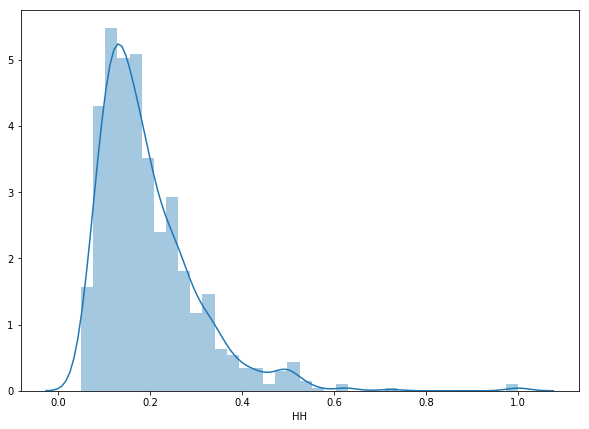

In [98]:
# HH per soc code
xx = (socd
 .assign(cluster = clusters)
 .groupby('soc')
 .apply(partial(hh, 'cluster'))
 .reset_index()
 .rename(columns = {0: 'HH'}))

sns.distplot(xx.HH)

In [106]:
bads = xx[xx.HH > 0.7].soc

In [112]:
socd.shape

(15548, 2)

In [113]:
xx.shape

(775, 2)

In [130]:
socd.task.unique().shape

(14074,)

In [ ]:
socd.groupby('soc').apply(lambda df: df.count())

In [119]:
socd.assign(cluster = clusters)[socd.soc.isin(bads)].merge(xx, on='soc')

      soc                                               task  cluster        HH
0  152091                                    using computers      104  1.000000
1  192011  Develop modify astronomy related programs for ...       31  1.000000
2  192011  determine sizes shapes brightness and motions ...       31  1.000000
3  193094  analyze interpret data such as election result...       34  0.722222
4  193094  reporting on findings recommendations and conc...       41  0.722222
5  193094  Interpret analyze policies public issues legis...       34  0.722222
6  193094  make related recommendations to institutions a...       34  0.722222
7  193094  prepare speeches correspondence and policy pap...       34  0.722222
8  193094  advise government officials civic bodies resea...       34  0.722222

In [81]:
CLUSTERS = 300

In [ ]:
clusters = cluster_tasks(CLUSTERS, vecs)
X,y = make_regression_data(socd, clusters)
cm, cbow = cluster_labellers(socd, clusters, vecs)

In [ ]:
from keras import models
from keras import layers
from keras import regularizers

def linear_model():
    model = models.Sequential()
    model.add(layers.Dense(1, input_dim=CLUSTERS, kernel_initializer='normal', kernel_regularizer=regularizers.l1(0.01)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
model = linear_model()
model.fit(X, y, validation_split=0.33, epochs = 25, batch_size=5)

In [86]:
def interpret_weights(w, lookup, thresh=0.003):
    descs = [lookup[i] for i in np.argwhere(np.abs(w) > thresh)[:,0]]    
    for v,d in zip(w[np.abs(w) > thresh], descs):
        print(v, d)

In [87]:
lookup = describe_clusters(socd, clusters, vecs)
lookup = {i: v.values for i,v in lookup.iterrows()}    

In [140]:
w = model.get_layer(index=0).get_weights()[0]
interpret_weights(w, lookup, 0.005)

-0.005162872 [21 'twist; old; understaffing; contraceptives; balancing'
 'checking prices' 0.0816326530612245]
0.027558347 [28 'abreast; lectures; disorders; stimulation; committees'
 'Compile maintain patients medical records document condition and treatment and'
 0.010005888197098797]
0.006800719 [55 'cope; usage; according; schemas; undercover'
 'according to specifications' 0.0061734693877551015]
-0.097015135 [73 'postage; pamphlets; enter; complaints; clerical'
 'perform clerical duties' 0.013277835587929238]
-0.014542916 [104 'participating; perceptual; using; radios; electrophoresis'
 'using computers' 0.0078125]
0.009468064 [124 'enlarger; user; networks; users; gathered'
 'provide technical information' 0.009644532506901048]
0.011784449 [126 'bonding; defects; engagements; portray; demand' 'locate defects'
 0.026172839506172843]
0.018537248 [128 'magnesium; violate; paperwork; complaints; locations'
 'resolve customers complaints regarding products or services'
 0.014233198227

In [ ]:
# interpret the results

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV()
lasso.fit(X, y)

In [274]:
lasso.alpha_

0.002272518565852948

In [ ]:
np.argwhere(np.abs(lasso.coef_) > 0.005)

In [ ]:
lasso.coef_[np.argwhere(np.abs(lasso.coef_) > 0.005)]

In [ ]:
pd.read_csv('')

In [ ]:
from spacy import displacy

displacy.render(parsed[2], style='dep', jupyter=True)

## ELMO Embedding

In [ ]:
from allennlp.commands.elmo import ElmoEmbedder

elmo = ElmoEmbedder()
v = elmo.embed_sentence([str(t) for t in parsed[0]])

In [ ]:
v.shape

(3, 21, 1024)